In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle
import seaborn as sns
import matplotlib.dates as mdates


In [2]:
#read the file tech_review_channels.tsv.gz
Tch_chan = pd.read_pickle("tech_review_channels (1).p",compression='gzip')
Tech_videos = pd.read_csv('yt_tech_channels_metadata.tsv.gz',compression='infer',sep='\t')

In [5]:
#Write a function that gives the last date a video was uploaded to a channel
def last_upload_date(channel_id):
    return Tech_videos[Tech_videos['channel_id']==channel_id]['upload_date'].max()




In [6]:
#Now the first date a video was uploaded to a channel
def first_upload_date(channel_id):
    return Tech_videos[Tech_videos['channel_id']==channel_id]['upload_date'].min()

In [7]:

def months_between_dates(date1,date2):
    return (date2.year-date1.year)*12 + (date2.month-date1.month)

In [8]:
#find the number of videos displayed on a channel
def num_videos(channel_id):
    return Tech_videos[Tech_videos['channel_id']==channel_id]['display_id'].count()

In [13]:
Tch_chan['last_upload_date'] = Tch_chan['channel_id'].apply(last_upload_date)

In [14]:
#Add column last upload date to Tch_chan
Tch_chan['first_upload_date'] = Tch_chan['channel_id'].apply(first_upload_date)

In [15]:
Tch_chan[Tch_chan['name_cc'].str.contains('boss')]

,category_cc,join_date,channel_id,name_cc,subscribers_cc,videos_cc,subscriber_rank_sb,weights,count_tech_videos,tech_videos_perc,first_upload_date,last_upload_date
12,Science & Technology,2011-04-20,UCMiJRAwDNSNzuYeN2uWa0pA,Mrwhosetheboss,2740000,1215,3367.0,2.289,423.0,0.348148,2011-04-22,2019-09-29


In [16]:
#Add column months between first and last upload date
Tch_chan['months_between_dates'] = Tch_chan.apply(lambda x: months_between_dates(pd.to_datetime(x['first_upload_date']),pd.to_datetime(x['last_upload_date'])),axis=1)

In [17]:
#gIVE THE monthly frequency of uploads as a new column
Tch_chan['monthly_frequency'] = Tch_chan.apply(lambda x:  x['count_tech_videos']/max(1,x['months_between_dates']),axis=1)

In [18]:
Tch_chan_freq = Tch_chan[['channel_id','subscribers_cc' ,'subscriber_rank_sb' ,'monthly_frequency']]

/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_4316/1796813055.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Tch_chan_freq['Subscriber Category'] = pd.cut(Tch_chan_freq['subscribers_cc'], bins=bin_edges)


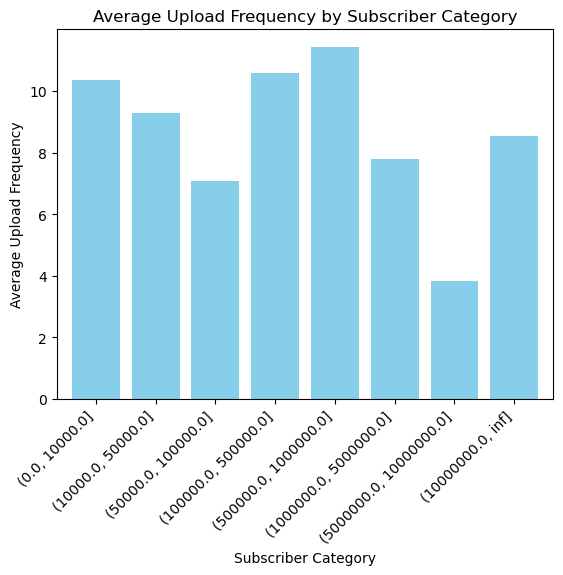

In [20]:
bin_edges = [0, 10000, 50000, 100000, 500000, 1000000, 5000000, 10000000, float('inf')]

# Create a new column to categorize subscribers into bins
Tch_chan_freq['Subscriber Category'] = pd.cut(Tch_chan_freq['subscribers_cc'], bins=bin_edges)

# Group by the 'Subscriber Category' and calculate the average upload frequency
average_uploads_by_subscribers = Tch_chan_freq.groupby('Subscriber Category')['monthly_frequency'].mean()

# Plot the histogram
average_uploads_by_subscribers.plot(kind='bar', width=0.8, color='skyblue')
plt.title('Average Upload Frequency by Subscriber Category')
plt.xlabel('Subscriber Category')
plt.ylabel('Average Upload Frequency')
plt.xticks(rotation=45, ha='right')
plt.show()

In [21]:
Tch_chan_freq['Rank Category'] = 10 - pd.qcut(Tch_chan_freq['subscriber_rank_sb'], q=10, labels=False)

/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_4316/1819207041.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Tch_chan_freq['Rank Category'] = 10 - pd.qcut(Tch_chan_freq['subscriber_rank_sb'], q=10, labels=False)


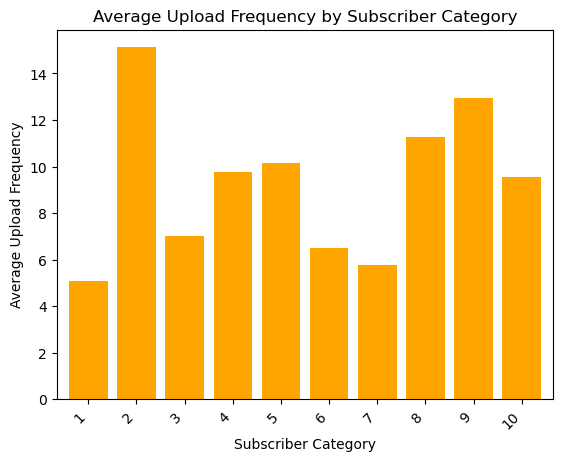

In [22]:
# Group by the 'Rank Category' and calculate the average upload frequency, the cateogry 10 is the top 10% of §ubscribers
average_uploads_by_subscribers = Tch_chan_freq.groupby('Rank Category')['monthly_frequency'].mean()
# Plot the histogram
average_uploads_by_subscribers.plot(kind='bar', width=0.8, color='orange')
plt.title('Average Upload Frequency by Subscriber Category')
plt.xlabel('Subscriber Category')
plt.ylabel('Average Upload Frequency')
plt.xticks(rotation=45, ha='right')
plt.show()

The thing to observe here, it's that very small youtubers upload a lot to try to progress and have more views, and that TOP tier youtuber upload a lot of ivdeos as they are doing it for a living for sure.

# Now , focus only on 4 youtubers , this will be generalized over bunch of youtubers for each category 


In [23]:
mylist =['Marques Brownlee','UrAvgConsumer','Unbox Therapy','Mrwhosetheboss']
list_ids = Tch_chan[Tch_chan['name_cc'].isin(mylist)][ 'channel_id'].unique()
names_and_ids = Tch_chan[Tch_chan['name_cc'].isin(mylist)][ ['name_cc' ,'channel_id']].drop_duplicates()
names_and_ids  

,name_cc,channel_id
0,Unbox Therapy,UCsTcErHg8oDvUnTzoqsYeNw
2,Marques Brownlee,UCBJycsmduvYEL83R_U4JriQ
12,Mrwhosetheboss,UCMiJRAwDNSNzuYeN2uWa0pA
19,UrAvgConsumer,UC9fSZHEh6XsRpX-xJc6lT3A


In [24]:
Tech_4_VID = Tech_videos[Tech_videos['channel_id'].isin(list_ids)]

In [25]:
TS = pd.read_table("df_timeseries_en.tsv")

In [26]:
Tech_4_VID['Release_Date'] = pd.to_datetime(Tech_4_VID['upload_date'])
# Sort the DataFrame by 'Release_Date'
Tech_4_VID = Tech_4_VID.sort_values('Release_Date')

/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_4316/3062517267.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Tech_4_VID['Release_Date'] = pd.to_datetime(Tech_4_VID['upload_date'])


In [27]:
TS_4 = TS[TS['channel'].isin(list_ids)]
Tech_4_VID_flt =Tech_4_VID[(TS_4['datetime'].max() >=Tech_4_VID['Release_Date']) & (Tech_4_VID['Release_Date']>= TS_4['datetime'].min())]

UnboxVID = Tech_4_VID_flt[Tech_4_VID_flt['channel_id']=='UCsTcErHg8oDvUnTzoqsYeNw']
MKBHDVID = Tech_4_VID_flt[Tech_4_VID_flt['channel_id']=='UCBJycsmduvYEL83R_U4JriQ']
UrAvgConsumerVID = Tech_4_VID_flt[Tech_4_VID_flt['channel_id']=='UC9fSZHEh6XsRpX-xJc6lT3A']
MrwhosethebossVID = Tech_4_VID_flt[Tech_4_VID_flt['channel_id']=='UCMiJRAwDNSNzuYeN2uWa0pA'] 

/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_4316/3728459742.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  MKBHDVID['Youtuber'] = 'MKBHD'
/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_4316/3728459742.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  UnboxVID['Youtuber'] = 'Unbox Therapy'
/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_4316/3728459742.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

<Figure size 3000x1700 with 0 Axes>

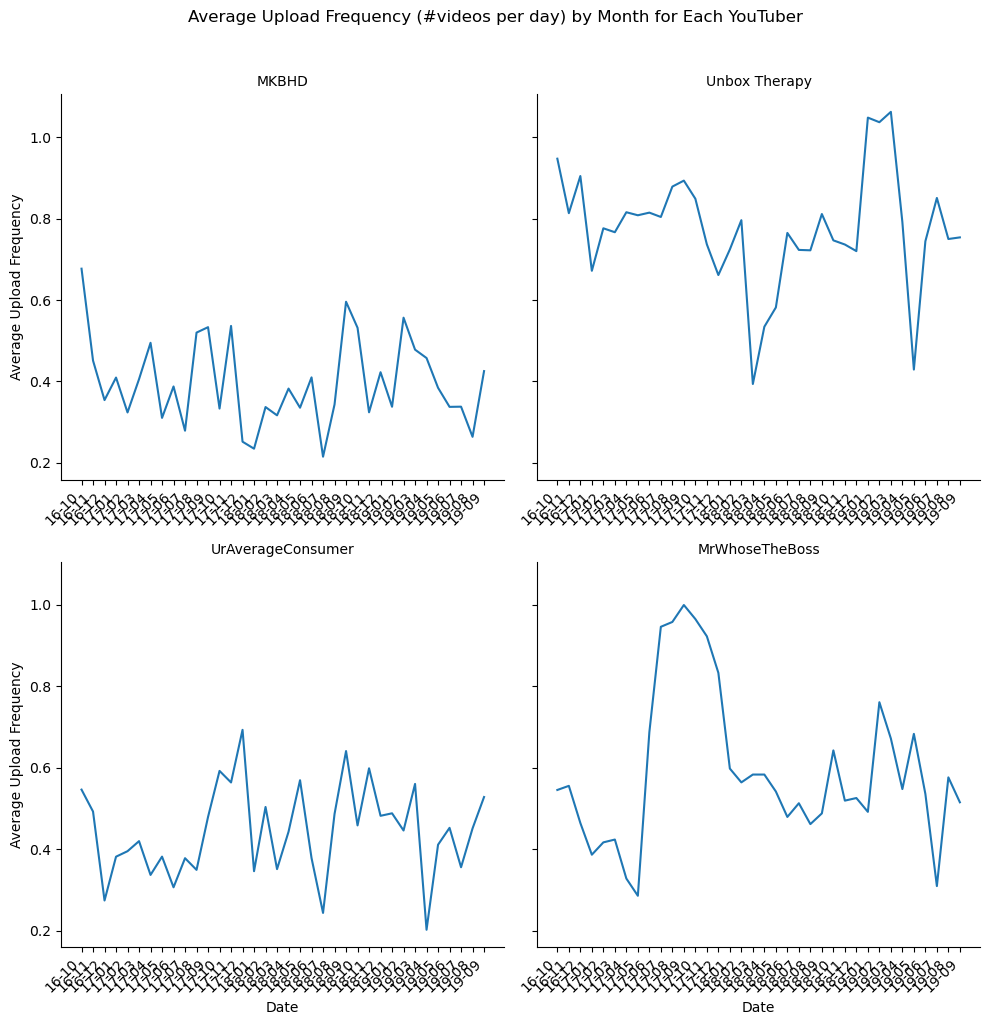

In [31]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have four DataFrames: youtuber1_df, youtuber2_df, youtuber3_df, youtuber4_df

# Add a 'Youtuber' column to each DataFrame
MKBHDVID['Youtuber'] = 'MKBHD'
UnboxVID['Youtuber'] = 'Unbox Therapy'
UrAvgConsumerVID['Youtuber'] = 'UrAverageConsumer'
MrwhosethebossVID['Youtuber'] = 'MrWhoseTheBoss'

# Combine the DataFrames into one
combined_df_freq = pd.concat([MKBHDVID, UnboxVID, UrAvgConsumerVID, MrwhosethebossVID])

combined_df_freq['FormattedDate'] = combined_df_freq['Release_Date'].dt.strftime('%y-%m')

# Set a wider figure size
plt.figure(figsize=(30, 17))

# Use seaborn to create a FacetGrid with one subplot for each Youtuber
g = sns.FacetGrid(combined_df_freq, col='Youtuber', col_wrap=2, height=5, margin_titles=True, sharex=False)
g.map_dataframe(sns.lineplot, x='FormattedDate', y='Frequency', ci=None)
g.set_axis_labels('Date', 'Average Upload Frequency')
g.set_titles(col_template="{col_name}")
g.set_xticklabels(rotation=45, ha='right')

plt.suptitle('Average Upload Frequency (#videos per day) by Month for Each YouTuber', y=1.02)
plt.tight_layout()
plt.show()

In [47]:
#plot the count of videos per year

MKBHDmonthly = MKBHDVID.copy()
Unboxmonthly = UnboxVID.copy()
UrAvgConsumermonthly = UrAvgConsumerVID.copy()
Mrwhosethebossmonthly = MrwhosethebossVID.copy()



MKBHDMonthly=  MKBHDVID.groupby(['Year', 'Month']).agg({'display_id': 'count', 'MonthlyFrequencyVAR': 'mean'}).reset_index()
Unboxmonthly = Unboxmonthly.groupby(['Year', 'Month']).agg({'display_id': 'count', 'MonthlyFrequencyVAR': 'mean'}).reset_index()
UrAvgConsumermonthly = UrAvgConsumermonthly.groupby(['Year', 'Month']).agg({'display_id': 'count', 'MonthlyFrequencyVAR': 'mean'}).reset_index()
Mrwhosethebossmonthly = Mrwhosethebossmonthly.groupby(['Year', 'Month']).agg({'display_id': 'count', 'MonthlyFrequencyVAR': 'mean'}).reset_index()










In [50]:
TS_MKBHD = TS_4[TS_4['channel']=='UCBJycsmduvYEL83R_U4JriQ'] 
TS_Unbox = TS_4[TS_4['channel']=='UCsTcErHg8oDvUnTzoqsYeNw'] 
TS_UrAvgConsumer = TS_4[TS_4['channel']=='UC9fSZHEh6XsRpX-xJc6lT3A']
TS_Mrwhosetheboss = TS_4[TS_4['channel']=='UCMiJRAwDNSNzuYeN2uWa0pA']

In [52]:
TS_MKBHD['datetime'] = pd.to_datetime(TS_MKBHD['datetime'])
TS_MKBHD['Year'] = TS_MKBHD['datetime'].dt.year
TS_MKBHD['Month'] = TS_MKBHD['datetime'].dt.month

TS_Unbox['datetime'] = pd.to_datetime(TS_Unbox['datetime'])
TS_Unbox['Year'] = TS_Unbox['datetime'].dt.year
TS_Unbox['Month'] = TS_Unbox['datetime'].dt.month

TS_UrAvgConsumer['datetime'] = pd.to_datetime(TS_UrAvgConsumer['datetime'])
TS_UrAvgConsumer['Year'] = TS_UrAvgConsumer['datetime'].dt.year
TS_UrAvgConsumer['Month'] = TS_UrAvgConsumer['datetime'].dt.month

TS_Mrwhosetheboss['datetime'] = pd.to_datetime(TS_Mrwhosetheboss['datetime'])
TS_Mrwhosetheboss['Year'] = TS_Mrwhosetheboss['datetime'].dt.year
TS_Mrwhosetheboss['Month'] = TS_Mrwhosetheboss['datetime'].dt.month



# Group by the 'Year' column and sum the 'Delta_Sub' values for each month of each year





/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_4316/2223096486.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  TS_MKBHD['datetime'] = pd.to_datetime(TS_MKBHD['datetime'])
/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_4316/2223096486.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  TS_MKBHD['Year'] = TS_MKBHD['datetime'].dt.year
/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_4316/2223096486.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

In [57]:
monthlyTS_MKBHD = TS_MKBHD.groupby(['Year', 'Month']).agg({'delta_subs': 'sum', 'subs': 'max'}).reset_index()
monthlyTS_Unbox = TS_Unbox.groupby(['Year', 'Month']).agg({'delta_subs': 'sum', 'subs': 'max'}).reset_index()
monthlyTS_UrAvgConsumer = TS_UrAvgConsumer.groupby(['Year', 'Month']).agg({'delta_subs': 'sum', 'subs': 'max'}).reset_index()
monthlyTS_Mrwhosetheboss = TS_Mrwhosetheboss.groupby(['Year', 'Month']).agg({'delta_subs': 'sum', 'subs': 'max'}).reset_index()

In [58]:
monthlyTS_MKBHD['Youtuber']='MKBHD'
monthlyTS_Unbox['Youtuber']='Unbox Therapy'
monthlyTS_UrAvgConsumer['Youtuber']='UrAverageConsumer'
monthlyTS_Mrwhosetheboss['Youtuber']='MrWhoseTheBoss'

In [60]:
monthlyTS_MKBHD['RelativeDeltaSubs'] = monthlyTS_MKBHD['delta_subs']/monthlyTS_MKBHD['subs']
monthlyTS_Unbox['RelativeDeltaSubs'] = monthlyTS_Unbox['delta_subs']/monthlyTS_Unbox['subs']
monthlyTS_UrAvgConsumer['RelativeDeltaSubs'] = monthlyTS_UrAvgConsumer['delta_subs']/monthlyTS_UrAvgConsumer['subs']
monthlyTS_Mrwhosetheboss['RelativeDeltaSubs'] = monthlyTS_Mrwhosetheboss['delta_subs']/monthlyTS_Mrwhosetheboss['subs']

In [63]:
MKBHDMonthly['Youtuber']='MKBHD'
Unboxmonthly['Youtuber']='Unbox Therapy'
UrAvgConsumermonthly['Youtuber']='UrAverageConsumer'
Mrwhosethebossmonthly['Youtuber']='MrWhoseTheBoss'


In [64]:
mergedMKBHD = pd.merge(MKBHDMonthly, monthlyTS_MKBHD, on=['Year', 'Month','Youtuber'])
mergedUnbox = pd.merge(Unboxmonthly, monthlyTS_Unbox, on=['Year', 'Month','Youtuber'])
mergedUrAvgConsumer = pd.merge(UrAvgConsumermonthly, monthlyTS_UrAvgConsumer, on=['Year', 'Month','Youtuber'])
mergedMrwhosetheboss = pd.merge(Mrwhosethebossmonthly, monthlyTS_Mrwhosetheboss, on=['Year', 'Month','Youtuber'])

In [80]:
mergedMKBHD['Monthly_Regularity']=mergedMKBHD['display_id']/mergedMKBHD['MonthlyFrequencyVAR']
mergedUnbox['Monthly_Regularity']=mergedUnbox['display_id']/mergedUnbox['MonthlyFrequencyVAR']
mergedUrAvgConsumer['Monthly_Regularity']=mergedUrAvgConsumer['display_id']/mergedUrAvgConsumer['MonthlyFrequencyVAR']
mergedMrwhosetheboss['Monthly_Regularity']=mergedMrwhosetheboss['display_id']/mergedMrwhosetheboss['MonthlyFrequencyVAR']



In [86]:
mergedMKBHD.rename(columns={'display_id': 'Video_Count'}, inplace=True)
mergedUnbox.rename(columns={'display_id': 'Video_Count'}, inplace=True)
mergedUrAvgConsumer.rename(columns={'display_id': 'Video_Count'}, inplace=True)
mergedMrwhosetheboss.rename(columns={'display_id': 'Video_Count'}, inplace=True)

In [90]:
combined_df = pd.concat([mergedMKBHD, mergedUnbox, mergedUrAvgConsumer, mergedMrwhosetheboss])

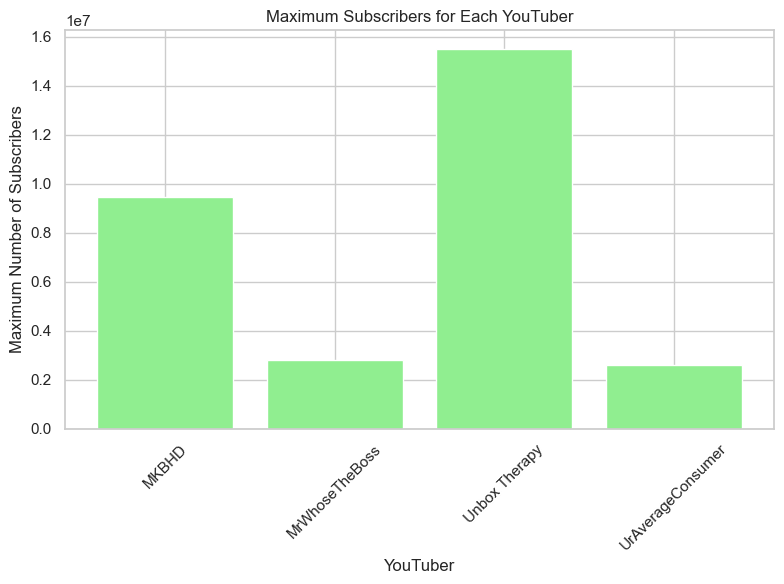

In [109]:
max_subscribers = combined_df.groupby('Youtuber')['subs'].max().reset_index()
plt.figure(figsize=(8, 6))
plt.bar(max_subscribers['Youtuber'], max_subscribers['subs'], color='lightgreen')
plt.xlabel('YouTuber')
plt.ylabel('Maximum Number of Subscribers')
plt.title('Maximum Subscribers for Each YouTuber')
plt.xticks(rotation=45)  # Rotating x-axis labels for better readability if needed
plt.tight_layout()

plt.show()


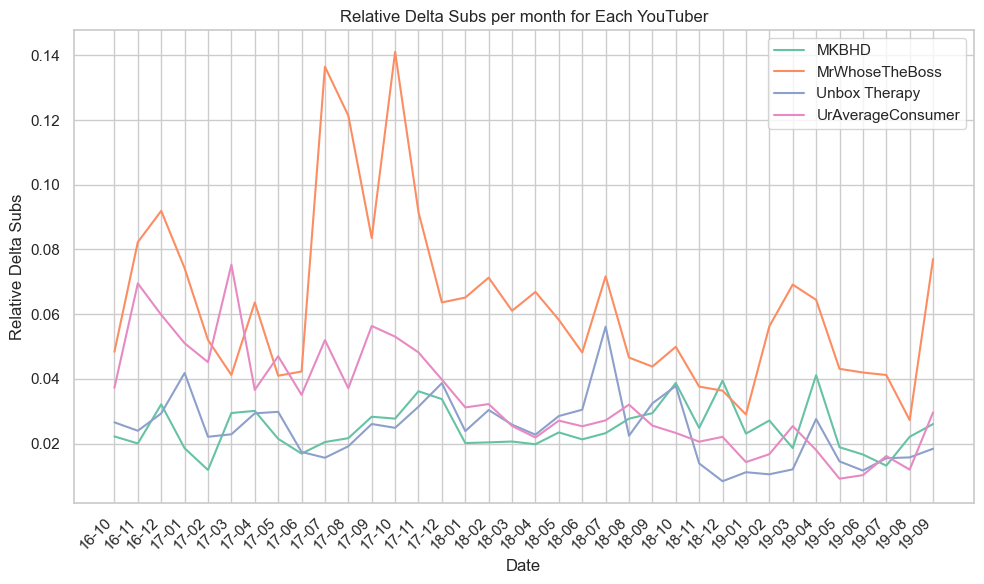

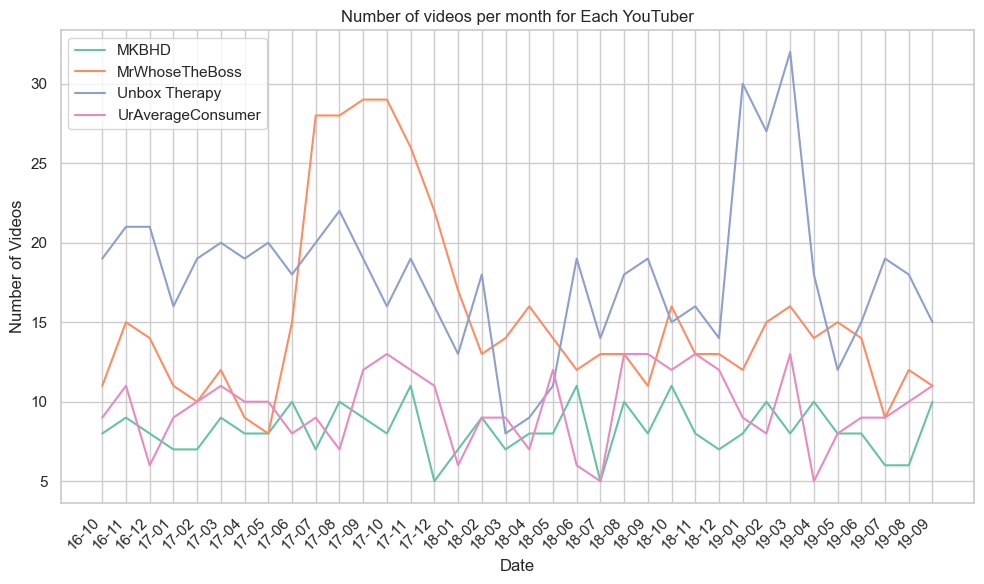

In [95]:

# Convert 'Year' and 'Month' to datetime format and create a new 'Date' column
combined_df['Date'] = pd.to_datetime(combined_df[['Year', 'Month']].assign(DAY=1))
# Format the 'Date' column as 'YY-MM'
combined_df['Date'] = combined_df['Date'].dt.strftime('%y-%m')
# Sort the DataFrame by the 'Date' column
combined_df = combined_df.sort_values(by='Date')
sns.set(style="whitegrid")
# Choose a color palette
palette = sns.color_palette("Set2")
# Assuming the necessary dataframes are defined

# Create a line plot for Relative Delta Subs
plt.figure(figsize=(10, 6))
for i, (youtuber, data) in enumerate(combined_df.groupby('Youtuber')):
    plt.plot(data['Date'], data['RelativeDeltaSubs'], label=youtuber, color=palette[i])

plt.title('Relative Delta Subs per month for Each YouTuber')
plt.xlabel('Date')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Relative Delta Subs')
plt.legend()
plt.tight_layout()
plt.show()

# Create a line plot for Number of videos per month
plt.figure(figsize=(10, 6))
for i, (youtuber, data) in enumerate(combined_df.groupby('Youtuber')):
    plt.plot(data['Date'], data['Video_Count'], label=youtuber, color=palette[i])

plt.title('Number of videos per month for Each YouTuber')
plt.xlabel('Date')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Number of Videos')
plt.legend()
plt.tight_layout()
plt.show()

In [104]:
#calculate the correlation between delta videos and delta subs for MKBHD
print("MKBHD:")
MKBHDcorr = mergedMKBHD['Video_Count'].corr(mergedMKBHD['RelativeDeltaSubs'])
print(MKBHDcorr, '\n')


#calculate the correlation between delta videos and delta subs for Unbox Therapy
print("Unbox Therapy:")
Unboxcorr = mergedUnbox['Video_Count'].corr(mergedUnbox['RelativeDeltaSubs'])
print(Unboxcorr , '\n')

print("UrAverageConsumer:")
UrAvgcorr = mergedUrAvgConsumer['Video_Count'].corr(mergedUrAvgConsumer['RelativeDeltaSubs'])
print(UrAvgcorr , '\n')

print("MrWhoseTheBoss:")
Mrwhosethebosscorr = mergedMrwhosetheboss['Video_Count'].corr(mergedMrwhosetheboss['RelativeDeltaSubs'])
print(Mrwhosethebosscorr, '\n')


print('On average:')
print(combined_df['Video_Count'].corr(combined_df['RelativeDeltaSubs']))


MKBHD:
0.2936335807052104 

Unbox Therapy:
-0.2990995509724465 

UrAverageConsumer:
0.1774939368878631 

MrWhoseTheBoss:
0.7628583575997314 

On average:
0.3423265352697864


Here we canno't observe really well the evolution as Unbox therapy has much more subscribers than the others

/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_4316/1412881326.py:10: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x='Date', y='RelativeDeltaSubs', hue='Youtuber', data=combined_df, ci=None, ax=ax1, palette=youtuber_palette)
/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_4316/1412881326.py:17: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x='Date', y='Monthly_Regularity', hue='Youtuber', data=combined_df, ci=None, ax=ax2, palette=youtuber_palette)


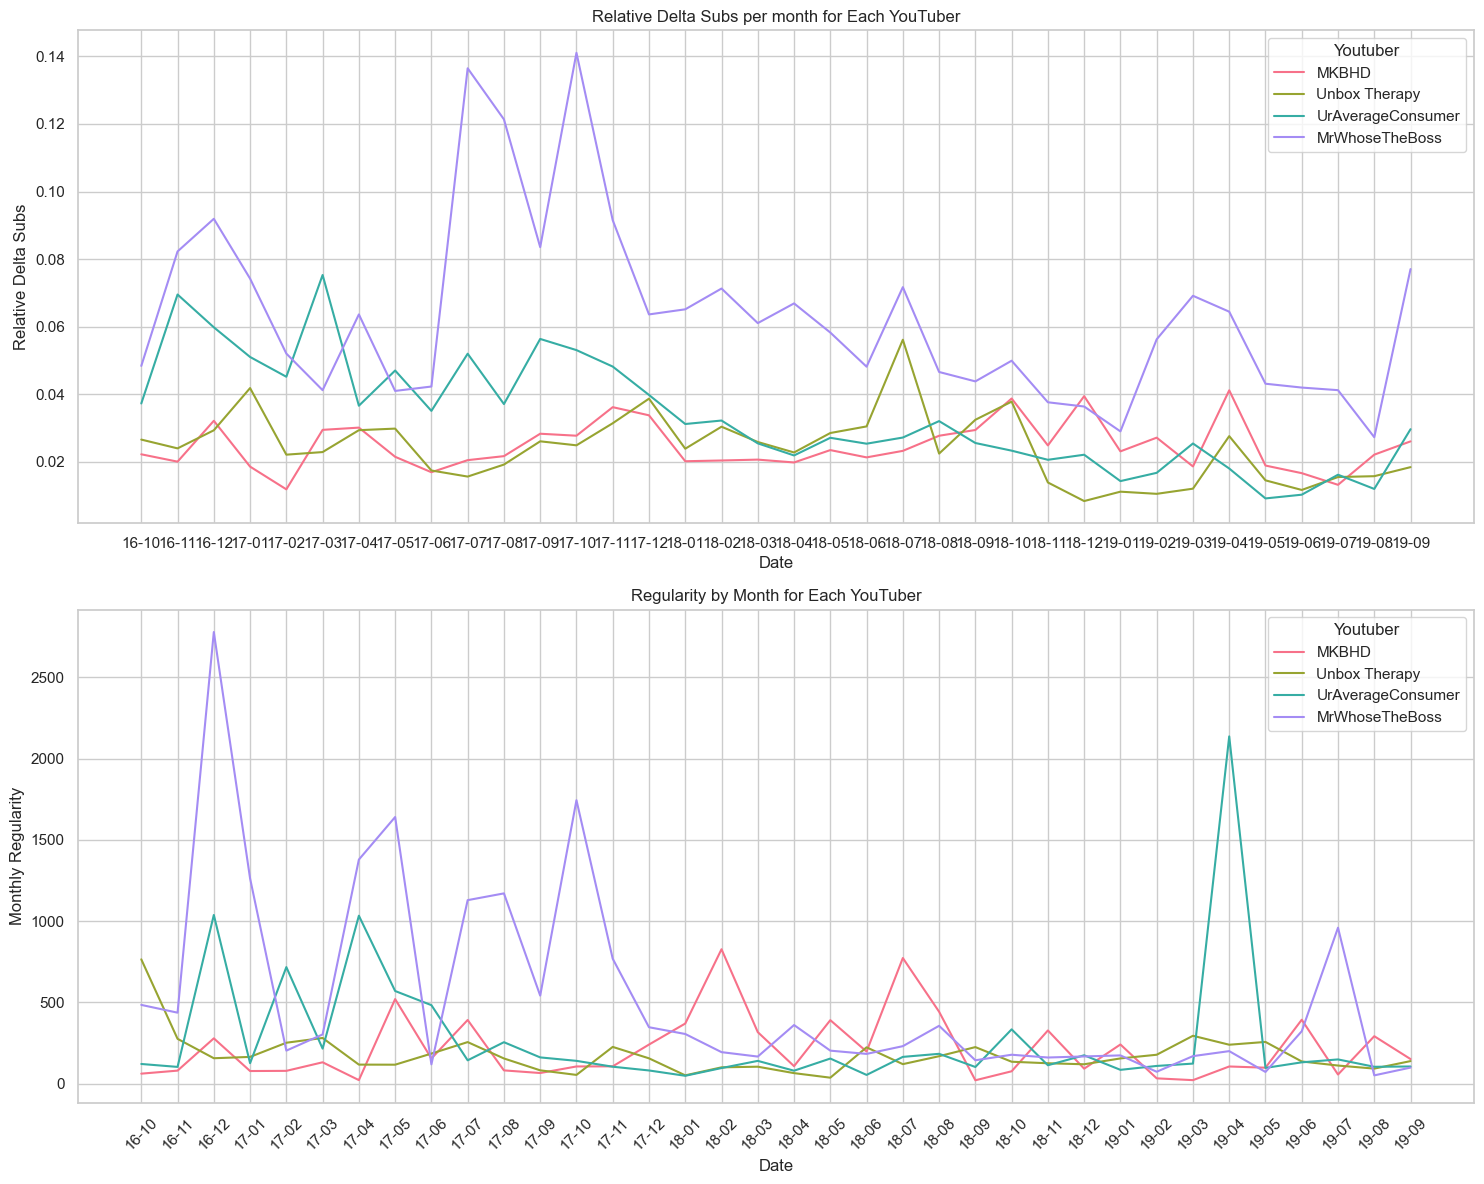

In [94]:

# Define a consistent palette for Youtubers
youtuber_palette = sns.color_palette("husl", n_colors=len(combined_df['Youtuber'].unique()))

sns.set(style="whitegrid")

# Create subplots with a consistent palette
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12), sharex=False)

# ---- First Subplot: Relative Delta Subs per month ----
sns.lineplot(x='Date', y='RelativeDeltaSubs', hue='Youtuber', data=combined_df, ci=None, ax=ax1, palette=youtuber_palette)
plt.xticks(rotation=45)
ax1.set_title('Relative Delta Subs per month for Each YouTuber')
ax1.set_ylabel('Relative Delta Subs')
ax1.legend(title='Youtuber')

# ---- Second Subplot: Average Upload Frequency per month ----
sns.lineplot(x='Date', y='Monthly_Regularity', hue='Youtuber', data=combined_df, ci=None, ax=ax2, palette=youtuber_palette)
ax2.set_title('Regularity by Month for Each YouTuber')
plt.xticks(rotation=45)
ax2.set_xlabel('Date')
ax2.set_ylabel('Monthly Regularity')
ax2.legend(title='Youtuber')

# Adjust layout
plt.tight_layout()
plt.show()

We can clearly observe the same trend, this is to be explored more generally     

In [105]:

#print correlations for each youtuber between regularity and relative delta subs
print('MKBHD: Correlation between Monthly Regularity and Relative Delta Subs')
print(mergedMKBHD['Monthly_Regularity'].corr(mergedMKBHD['RelativeDeltaSubs']), '\n')
print('Unbox Therapy: Correlation between Monthly Regularity and Relative Delta Subs')
print(mergedUnbox['Monthly_Regularity'].corr(mergedUnbox['RelativeDeltaSubs']), '\n')
print('UrAverageConsumer: Correlation between Monthly Regularity and Relative Delta Subs')
print(mergedUrAvgConsumer['Monthly_Regularity'].corr(mergedUrAvgConsumer['RelativeDeltaSubs']), '\n')
print('MrWhoseTheBoss: Correlation between Monthly Regularity and Relative Delta Subs')
print(mergedMrwhosetheboss['Monthly_Regularity'].corr(mergedMrwhosetheboss['RelativeDeltaSubs']), '\n')


print('on average:')
print(combined_df['Monthly_Regularity'].corr(combined_df['RelativeDeltaSubs']))




MKBHD: Correlation between Monthly Regularity and Relative Delta Subs
-0.17412497452777903 

Unbox Therapy: Correlation between Monthly Regularity and Relative Delta Subs
-0.039021994429198834 

UrAverageConsumer: Correlation between Monthly Regularity and Relative Delta Subs
0.05630108487815437 

MrWhoseTheBoss: Correlation between Monthly Regularity and Relative Delta Subs
0.5398005184290603 

on average:
0.4704160212324766
